# 01 — Analyse Exploratoire des Données (EDA)
## Projet HVAC Market Analysis — Région AURA

**Objectif** : Explorer et comprendre le dataset HVAC avant la modélisation ML.

**Plan de ce notebook** :
1. Chargement et vue d'ensemble du dataset
2. Analyse des valeurs manquantes
3. Distribution des variables cibles
4. Séries temporelles et tendances
5. Saisonnalité du marché HVAC
6. Comparaison entre départements
7. Corrélations entre variables
8. Conclusions pour la modélisation

In [1]:
# ============================================================
# IMPORTS ET CONFIGURATION
# ============================================================
import sys
sys.path.insert(0, '..')  # Pour importer les modules du projet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('Set2')

# Affichage complet des DataFrames
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

print('Imports OK')

Imports OK


---
## 1. Chargement et vue d'ensemble du dataset

Le dataset ML-ready contient les données agrégées par **mois × département** :
- 8 départements AURA (Ain, Ardèche, Drôme, Isère, Loire, Rhône, Savoie, Haute-Savoie)
- Période DPE v2 : juillet 2021 → décembre 2025
- Variables cibles : installations PAC, climatisation, DPE total

In [2]:
# ============================================================
# 1.1 — Charger le dataset ML-ready
# ============================================================
# Ce dataset est produit par : python -m src.pipeline merge
# Grain : mois × département (8 depts × ~54 mois = ~432 lignes)

df = pd.read_csv('../data/features/hvac_ml_dataset.csv')

print(f'Dataset ML-ready : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print(f'Période : {df["date_id"].min()} → {df["date_id"].max()}')
print(f'Départements : {sorted(df["dept"].unique())}')
print(f'\nTypes de colonnes :')
print(df.dtypes.value_counts())

Dataset ML-ready : 432 lignes × 34 colonnes
Période : 202107 → 202512
Départements : [1, 7, 26, 38, 42, 69, 73, 74]

Types de colonnes :
float64    19
int64      13
object      2
Name: count, dtype: int64


In [3]:
# ============================================================
# 1.2 — Aperçu des premières lignes
# ============================================================
df.head(10)

,date_id,dept,nb_dpe_total,nb_installations_pac,nb_installations_clim,nb_dpe_classe_ab,pct_pac,pct_clim,pct_classe_ab,temp_mean,temp_max,temp_min,hdd_sum,cdd_sum,precipitation_sum,nb_jours_canicule,nb_jours_gel,confiance_menages,climat_affaires_indus,climat_affaires_bat,ipi_manufacturing,ipi_hvac_c28,ipi_hvac_c2825,year,month,quarter,is_heating,is_cooling,month_sin,month_cos,dept_name,city_ref,latitude,longitude
0,202107,1,255,13,9,10,5.10,3.53,3.92,23.99,30.92,18.60,0.00,177.46,52.98,2,0,90.26,97.90,102.14,97.23,87.55,99.75,2021,7,3,0,1,-0.50,-0.87,Ain,Bourg-en-Bresse,46.21,5.23
1,202107,7,166,11,7,7,6.63,4.22,4.22,20.96,25.29,15.24,14.17,75.92,86.17,4,0,88.32,106.64,109.49,99.38,95.16,91.65,2021,7,3,0,1,-0.50,-0.87,Ardeche,Privas,44.74,4.60
2,202107,26,227,19,7,13,8.37,3.08,5.73,23.12,27.69,20.07,0.00,136.53,40.63,2,0,92.48,95.89,111.33,97.40,101.88,97.14,2021,7,3,0,1,-0.50,-0.87,Drome,Valence,44.93,4.89
3,202107,38,428,26,19,18,6.07,4.44,4.21,23.48,28.59,16.80,0.00,182.03,107.19,1,0,91.78,98.19,105.98,97.73,93.48,98.11,2021,7,3,0,1,-0.50,-0.87,Isere,Grenoble,45.19,5.72
4,202107,42,315,20,13,13,6.35,4.13,4.13,23.82,28.40,18.05,11.02,175.98,70.92,4,0,94.97,97.54,104.36,101.02,102.81,98.88,2021,7,3,0,1,-0.50,-0.87,Loire,Saint-Etienne,45.44,4.39
5,202107,69,633,40,25,32,6.32,3.95,5.06,22.51,29.79,15.51,8.69,128.48,34.70,5,0,90.48,96.60,103.58,98.50,96.20,100.83,2021,7,3,0,1,-0.50,-0.87,Rhone,Lyon,45.76,4.84
6,202107,73,97,7,3,5,7.22,3.09,5.15,21.94,26.85,15.41,7.71,91.88,21.28,0,0,90.55,104.40,114.80,101.35,98.33,95.18,2021,7,3,0,1,-0.50,-0.87,Savoie,Chambery,45.57,5.92
7,202107,74,298,22,12,18,7.38,4.03,6.04,22.95,29.92,16.87,0.00,129.12,59.89,5,0,92.35,94.86,109.40,95.70,99.32,90.93,2021,7,3,0,1,-0.50,-0.87,Haute-Savoie,Annecy,45.90,6.13
8,202108,1,205,12,9,7,5.85,4.39,3.41,20.59,27.73,16.79,0.00,103.39,71.83,0,0,88.60,101.54,102.02,99.14,95.62,104.28,2021,8,3,0,1,-0.87,-0.50,Ain,Bourg-en-Bresse,46.21,5.23
9,202108,7,144,8,5,6,5.56,3.47,4.17,23.01,27.75,16.54,0.00,157.41,81.68,4,0,92.64,102.88,104.58,104.34,95.32,104.02,2021,8,3,0,1,-0.87,-0.50,Ardeche,Privas,44.74,4.60


In [4]:
# ============================================================
# 1.3 — Statistiques descriptives globales
# ============================================================
# .describe() donne count, mean, std, min, quartiles, max
# pour toutes les colonnes numériques

df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
date_id,432.00,202329.06,131.10,202107.00,202208.00,202309.50,202411.00,202512.00
dept,432.00,41.25,27.16,1.00,21.25,40.00,70.00,74.00
nb_dpe_total,432.00,289.51,152.81,10.00,185.00,258.00,340.00,749.00
nb_installations_pac,432.00,34.38,20.83,0.00,19.00,30.00,44.00,104.00
nb_installations_clim,432.00,9.24,5.70,0.00,5.00,8.00,12.00,30.00
...,...,...,...,...,...,...,...,...
is_cooling,432.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
month_sin,432.00,-0.07,0.70,-1.00,-0.87,0.00,0.50,1.00
month_cos,432.00,0.02,0.71,-1.00,-0.50,0.00,0.87,1.00
latitude,432.00,45.47,0.47,44.74,45.12,45.50,45.80,46.21


---
## 2. Analyse des valeurs manquantes

Les NaN peuvent provenir de :
- Données économiques indisponibles pour certains mois
- Mois sans DPE dans un département donné
- Indicateurs Eurostat non encore publiés

In [5]:
# ============================================================
# 2.1 — Comptage des NaN par colonne
# ============================================================
null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
null_cols = null_pct[null_pct > 0]

if len(null_cols) > 0:
    print(f'{len(null_cols)} colonnes avec des NaN :')
    for col, pct in null_cols.items():
        print(f'  {col:40s} : {pct:.1f}% ({df[col].isna().sum()} valeurs)')
else:
    print('Aucun NaN dans le dataset ML-ready !')

Aucun NaN dans le dataset ML-ready !


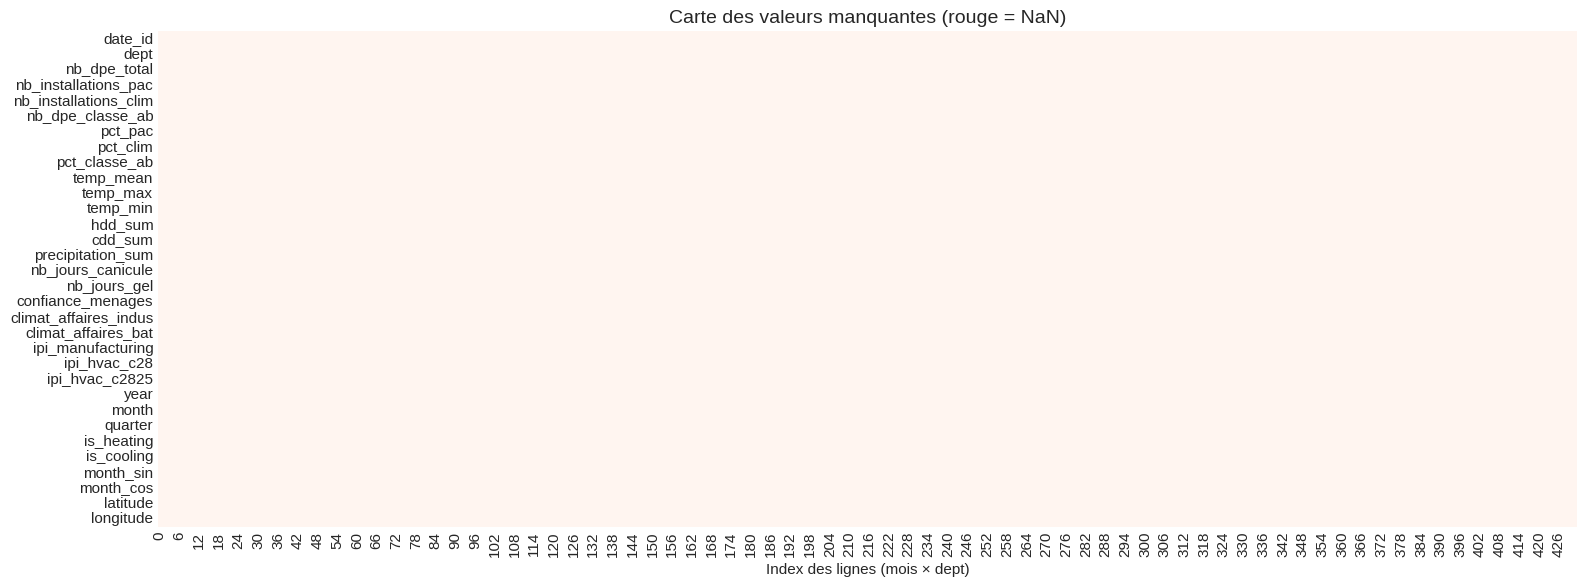

In [6]:
# ============================================================
# 2.2 — Heatmap des NaN (visualisation matricielle)
# ============================================================
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(
    df.select_dtypes(include=[np.number]).isna().T,
    cbar=False, cmap='Reds', yticklabels=True,
    ax=ax
)
ax.set_title('Carte des valeurs manquantes (rouge = NaN)', fontsize=14)
ax.set_xlabel('Index des lignes (mois × dept)')
plt.tight_layout()
plt.show()

---
## 3. Distribution des variables cibles

Nos variables cibles principales :
- **nb_installations_pac** : nombre de DPE mentionnant une PAC (proxy des ventes PAC)
- **nb_installations_clim** : nombre de DPE avec climatisation
- **nb_dpe_total** : volume total de DPE (indicateur d'activité immobilière)
- **nb_dpe_classe_ab** : DPE classe A ou B (bâtiments performants)

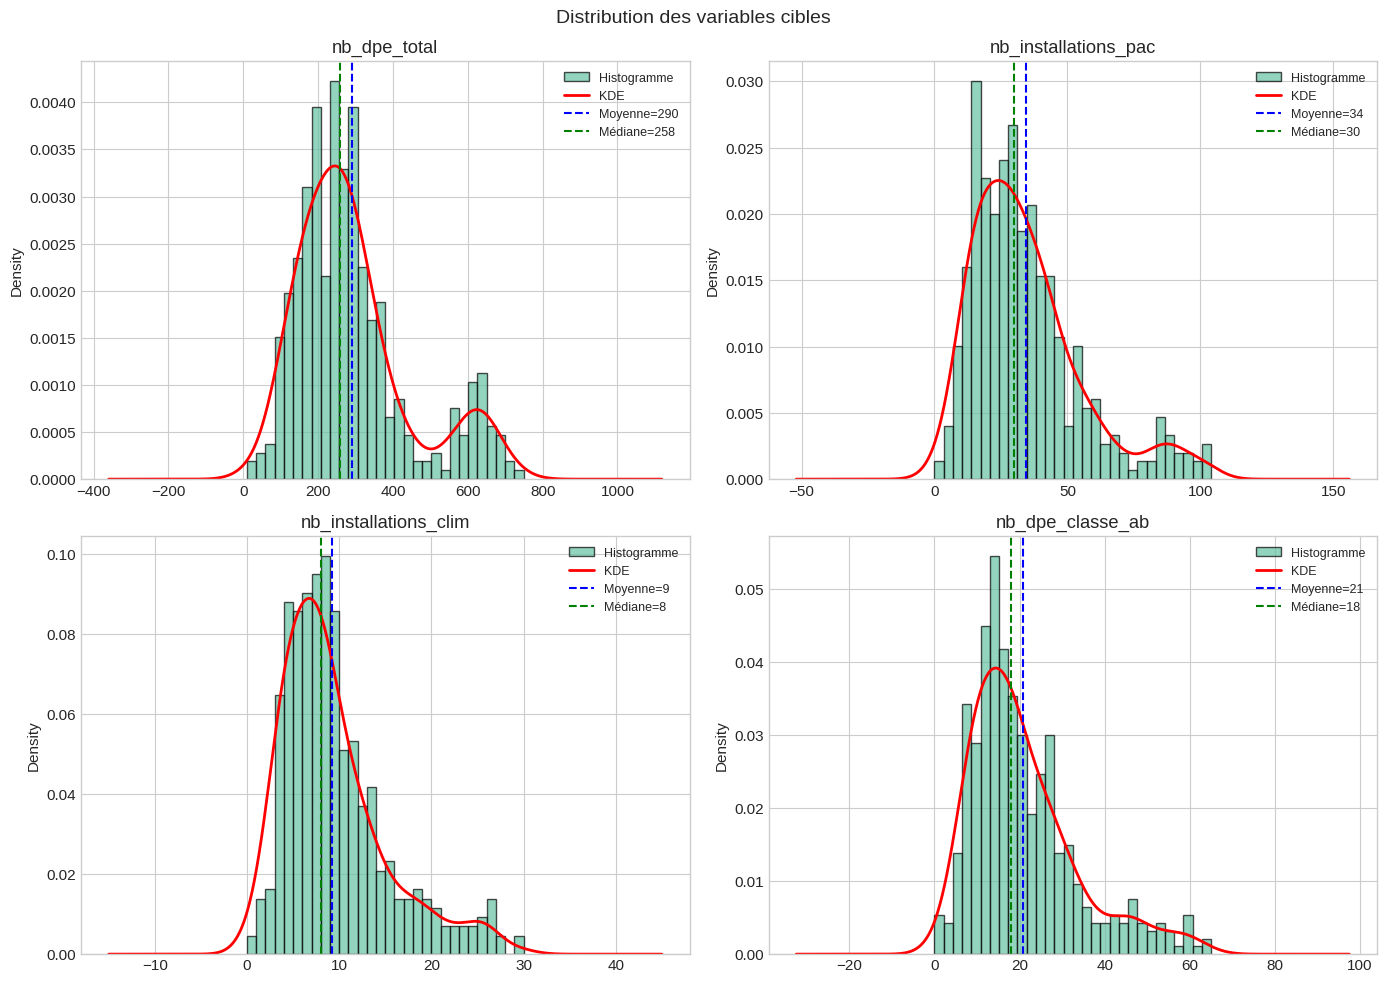

In [7]:
# ============================================================
# 3.1 — Histogrammes des 4 variables cibles
# ============================================================
targets = ['nb_dpe_total', 'nb_installations_pac', 
           'nb_installations_clim', 'nb_dpe_classe_ab']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution des variables cibles', fontsize=14)

for ax, col in zip(axes.flat, targets):
    # Histogramme + courbe KDE (densité)
    ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7, density=True, label='Histogramme')
    df[col].plot(kind='kde', ax=ax, color='red', linewidth=2, label='KDE')
    
    # Statistiques sur le graphique
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='blue', linestyle='--', label=f'Moyenne={mean_val:.0f}')
    ax.axvline(median_val, color='green', linestyle='--', label=f'Médiane={median_val:.0f}')
    
    ax.set_title(col)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

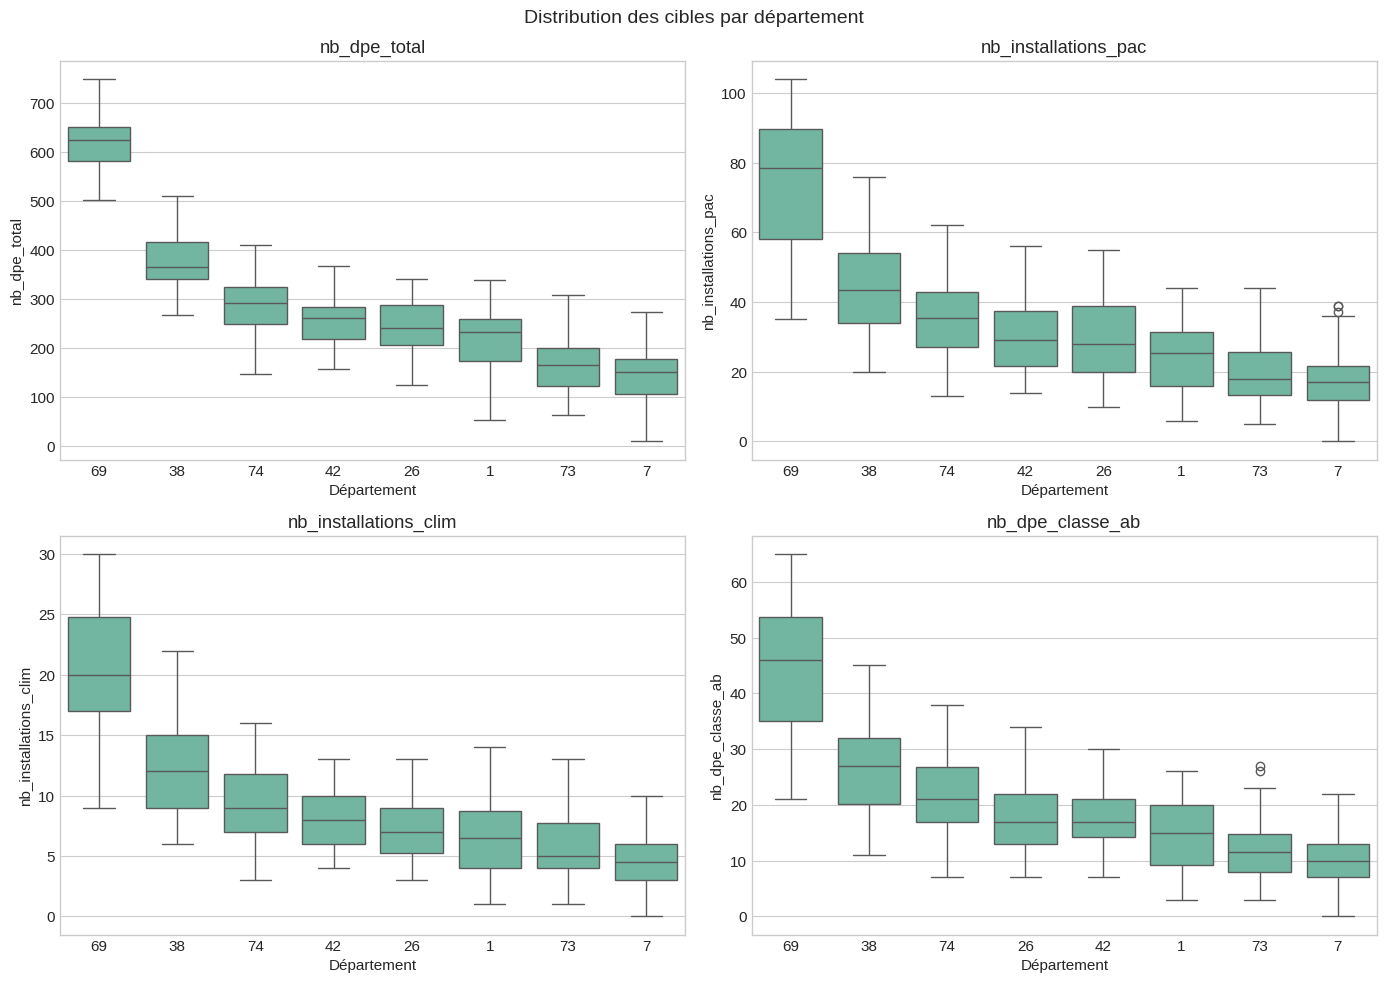

In [8]:
# ============================================================
# 3.2 — Boxplots des cibles par département
# ============================================================
# Montre la variabilité et les outliers par département

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution des cibles par département', fontsize=14)

for ax, col in zip(axes.flat, targets):
    # Trier les départements par médiane décroissante
    order = df.groupby('dept')[col].median().sort_values(ascending=False).index
    sns.boxplot(data=df, x='dept', y=col, order=order, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Département')

plt.tight_layout()
plt.show()

---
## 4. Séries temporelles et tendances

Examinons l'évolution mensuelle des variables cibles pour détecter :
- Les **tendances** à long terme (croissance du marché PAC ?)
- La **saisonnalité** (pics d'installations en hiver/été ?)
- Les **anomalies** (mois inhabituels)

In [9]:
# ============================================================
# 4.1 — Préparer l'axe temporel
# ============================================================
# Convertir date_id (YYYYMM) en datetime pour les graphiques

df['date'] = pd.to_datetime(
    df['date_id'].astype(str).str[:4] + '-' + 
    df['date_id'].astype(str).str[4:] + '-01'
)

# Agréger au niveau AURA (somme des 8 départements)
df_aura = df.groupby('date').agg({
    'nb_dpe_total': 'sum',
    'nb_installations_pac': 'sum',
    'nb_installations_clim': 'sum',
    'nb_dpe_classe_ab': 'sum',
    'temp_mean': 'mean',
    'hdd_sum': 'sum',
    'cdd_sum': 'sum',
}).reset_index()

print(f'Série temporelle AURA : {len(df_aura)} mois')

Série temporelle AURA : 54 mois


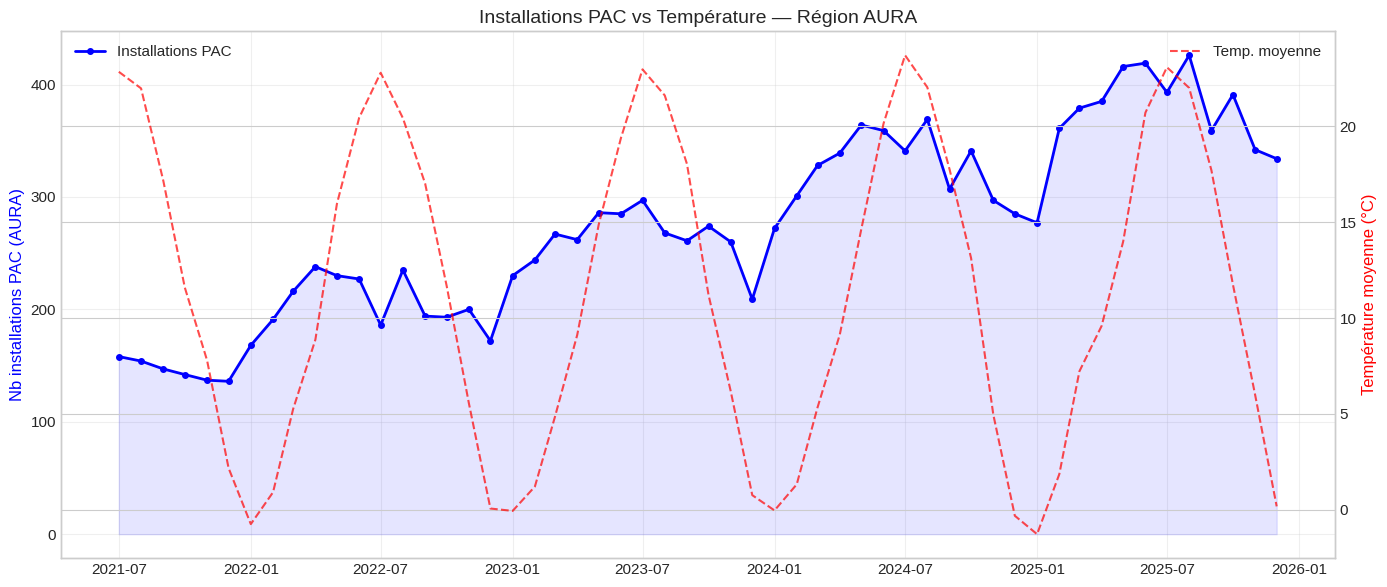

In [10]:
# ============================================================
# 4.2 — Évolution des installations PAC (AURA agrégé)
# ============================================================
fig, ax1 = plt.subplots(figsize=(14, 6))

# Installations PAC
ax1.plot(df_aura['date'], df_aura['nb_installations_pac'], 
         'b-o', markersize=4, label='Installations PAC', linewidth=2)
ax1.fill_between(df_aura['date'], df_aura['nb_installations_pac'], alpha=0.1, color='blue')
ax1.set_ylabel('Nb installations PAC (AURA)', color='blue', fontsize=12)

# Température moyenne en superposition
ax2 = ax1.twinx()
ax2.plot(df_aura['date'], df_aura['temp_mean'], 
         'r--', alpha=0.7, label='Temp. moyenne', linewidth=1.5)
ax2.set_ylabel('Température moyenne (°C)', color='red', fontsize=12)

ax1.set_title('Installations PAC vs Température — Région AURA', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

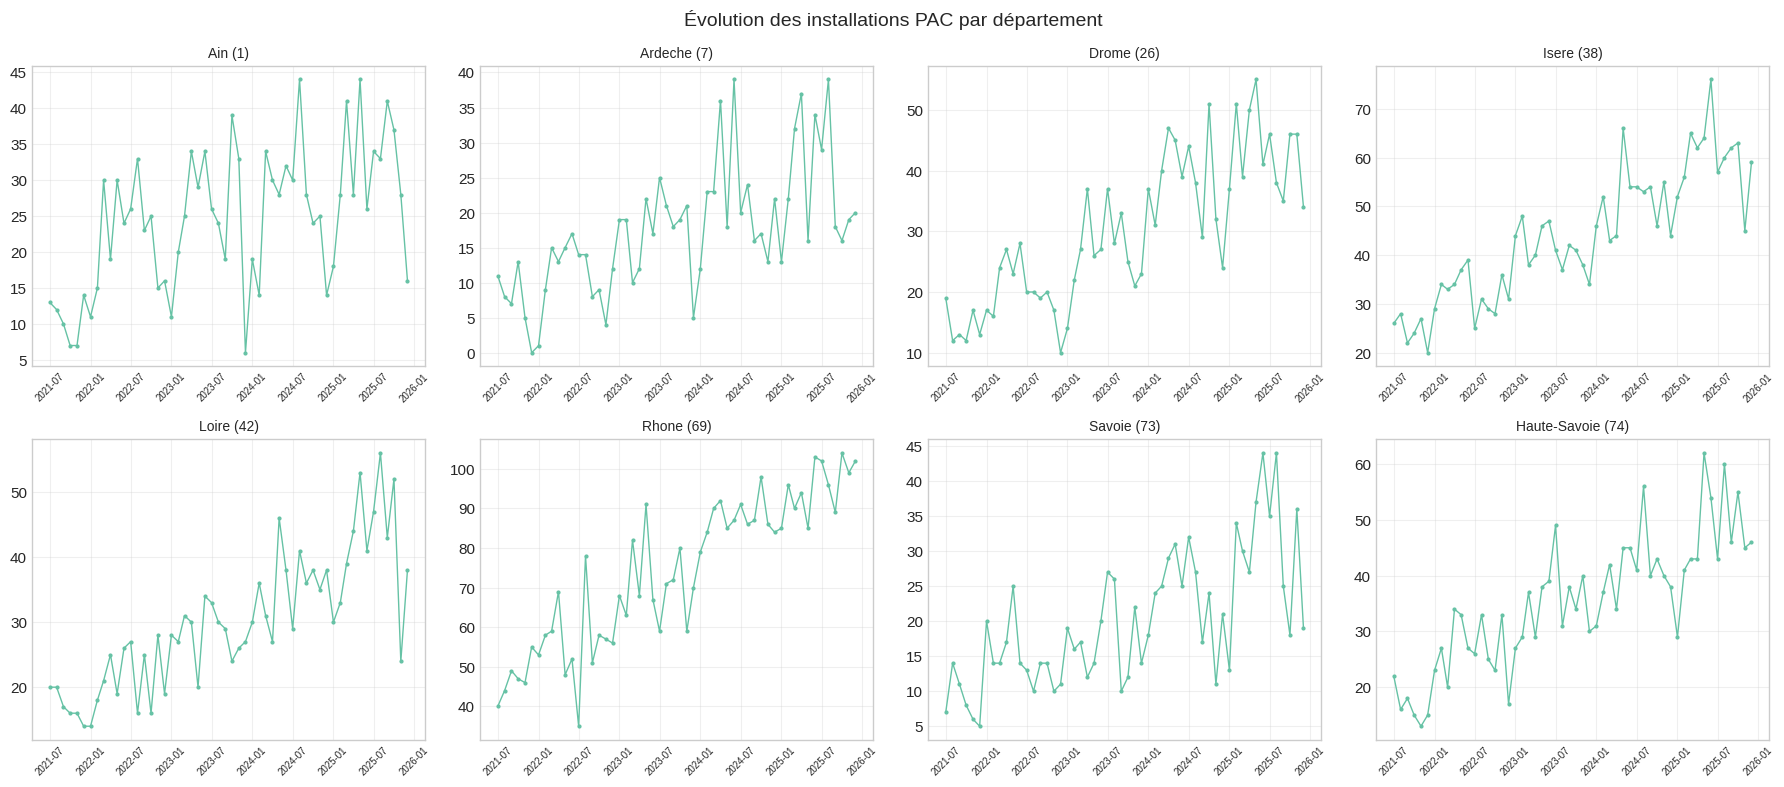

In [11]:
# ============================================================
# 4.3 — Séries temporelles par département
# ============================================================
fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharey=False)
fig.suptitle('Évolution des installations PAC par département', fontsize=14)

for ax, dept in zip(axes.flat, sorted(df['dept'].unique())):
    dept_data = df[df['dept'] == dept].sort_values('date')
    dept_name = dept_data['dept_name'].iloc[0] if 'dept_name' in dept_data.columns else dept
    
    ax.plot(dept_data['date'], dept_data['nb_installations_pac'], 
            '-o', markersize=2, linewidth=1)
    ax.set_title(f'{dept_name} ({dept})', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. Saisonnalité du marché HVAC

Hypothèses métier :
- **Chauffage (PAC)** : pic d'installations à l'automne (anticipation de l'hiver)
- **Climatisation** : pic au printemps/début été (avant les canicules)
- **DPE total** : lié aux transactions immobilières (pic au printemps)

/tmp/ipykernel_9032/1693329072.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mois_labels, rotation=45)
/tmp/ipykernel_9032/1693329072.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mois_labels, rotation=45)
/tmp/ipykernel_9032/1693329072.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mois_labels, rotation=45)
/tmp/ipykernel_9032/1693329072.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mois_labels, rotation=45)


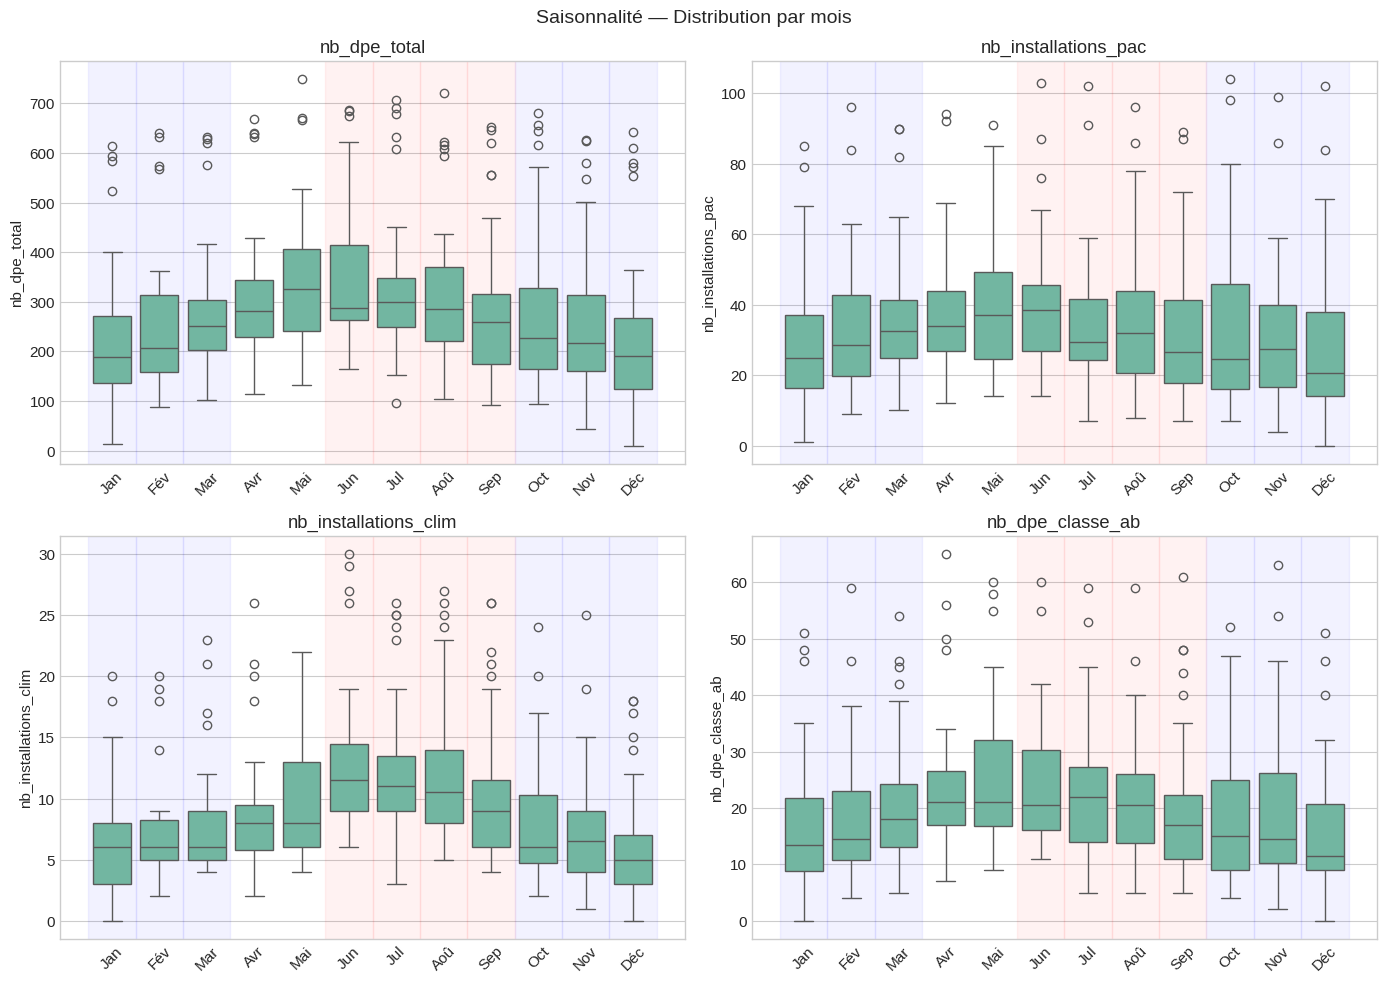

In [12]:
# ============================================================
# 5.1 — Boxplots saisonniers (par mois)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Saisonnalité — Distribution par mois', fontsize=14)

mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun',
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']

for ax, col in zip(axes.flat, targets):
    sns.boxplot(data=df, x='month', y=col, ax=ax)
    ax.set_xticklabels(mois_labels, rotation=45)
    ax.set_title(col)
    ax.set_xlabel('')
    
    # Colorier les saisons
    for i in range(12):
        if i+1 in [10, 11, 12, 1, 2, 3]:  # Chauffage
            ax.axvspan(i-0.5, i+0.5, alpha=0.05, color='blue')
        elif i+1 in [6, 7, 8, 9]:  # Climatisation
            ax.axvspan(i-0.5, i+0.5, alpha=0.05, color='red')

plt.tight_layout()
plt.show()

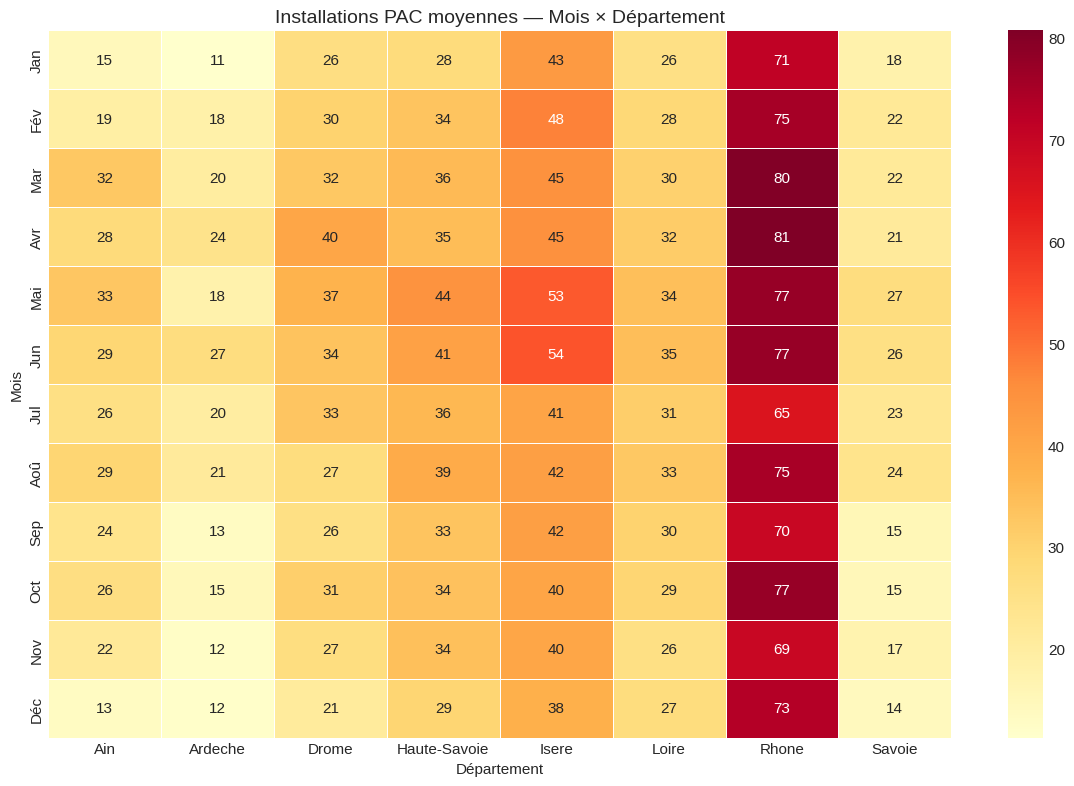

In [13]:
# ============================================================
# 5.2 — Heatmap mois × département (installations PAC)
# ============================================================
# Pivot : lignes = mois, colonnes = département, valeurs = PAC moyen

pivot_pac = df.pivot_table(
    values='nb_installations_pac', 
    index='month', 
    columns='dept_name' if 'dept_name' in df.columns else 'dept',
    aggfunc='mean'
)
pivot_pac.index = mois_labels

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    pivot_pac, annot=True, fmt='.0f', cmap='YlOrRd',
    linewidths=0.5, ax=ax
)
ax.set_title('Installations PAC moyennes — Mois × Département', fontsize=14)
ax.set_xlabel('Département')
ax.set_ylabel('Mois')
plt.tight_layout()
plt.show()

---
## 6. Comparaison entre départements

In [14]:
# ============================================================
# 6.1 — Volume moyen par département
# ============================================================
col_name = 'dept_name' if 'dept_name' in df.columns else 'dept'
dept_stats = df.groupby(col_name).agg({
    'nb_dpe_total': 'mean',
    'nb_installations_pac': 'mean',
    'nb_installations_clim': 'mean',
    'pct_pac': 'mean',
}).round(1).sort_values('nb_dpe_total', ascending=False)

print('Statistiques moyennes par département :')
dept_stats

Statistiques moyennes par département :


,nb_dpe_total,nb_installations_pac,nb_installations_clim,pct_pac
dept_name,,,,
Rhone,621.70,74.10,20.30,11.90
Isere,374.40,43.70,12.10,11.60
Haute-Savoie,289.10,35.20,9.40,12.00
Loire,256.40,30.00,8.00,11.60
Drome,246.10,30.00,7.30,11.90
Ain,213.90,24.60,6.60,11.50
Savoie,167.70,20.00,5.50,11.70
Ardeche,146.90,17.40,4.70,11.40


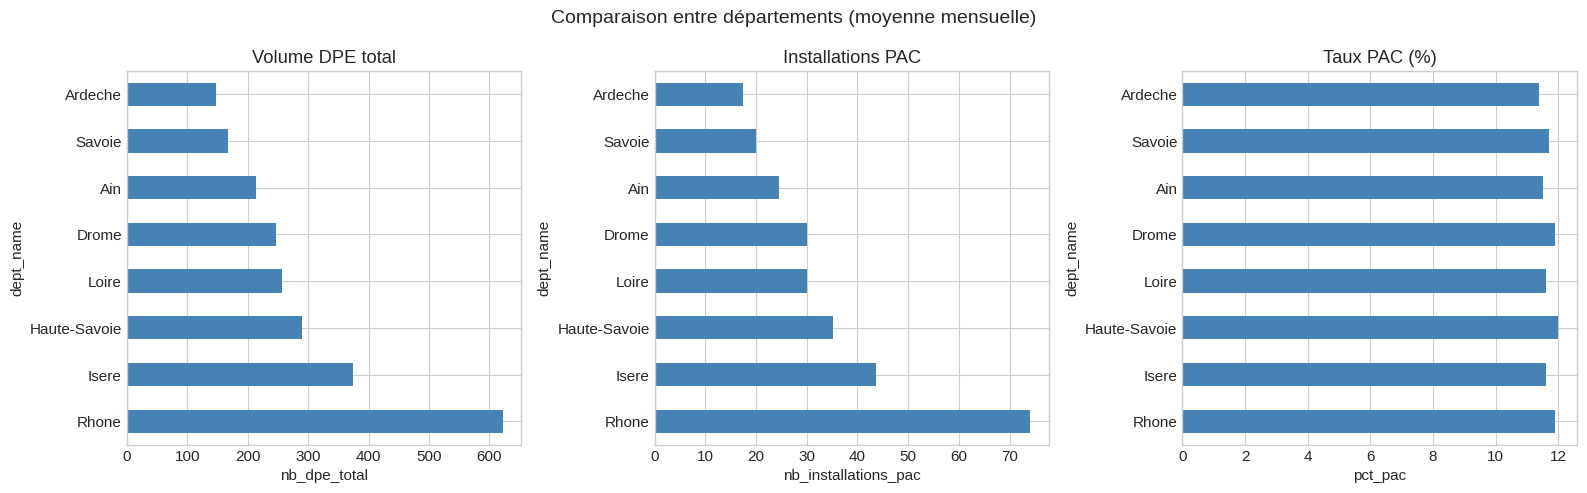

In [15]:
# ============================================================
# 6.2 — Barres comparatives
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Comparaison entre départements (moyenne mensuelle)', fontsize=14)

for ax, col, title in zip(axes, 
    ['nb_dpe_total', 'nb_installations_pac', 'pct_pac'],
    ['Volume DPE total', 'Installations PAC', 'Taux PAC (%)']):
    
    dept_stats[col].plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(title)
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

---
## 7. Corrélations entre variables

Objectif : identifier les features les plus corrélées avec nos cibles
pour guider la sélection de features dans la modélisation.

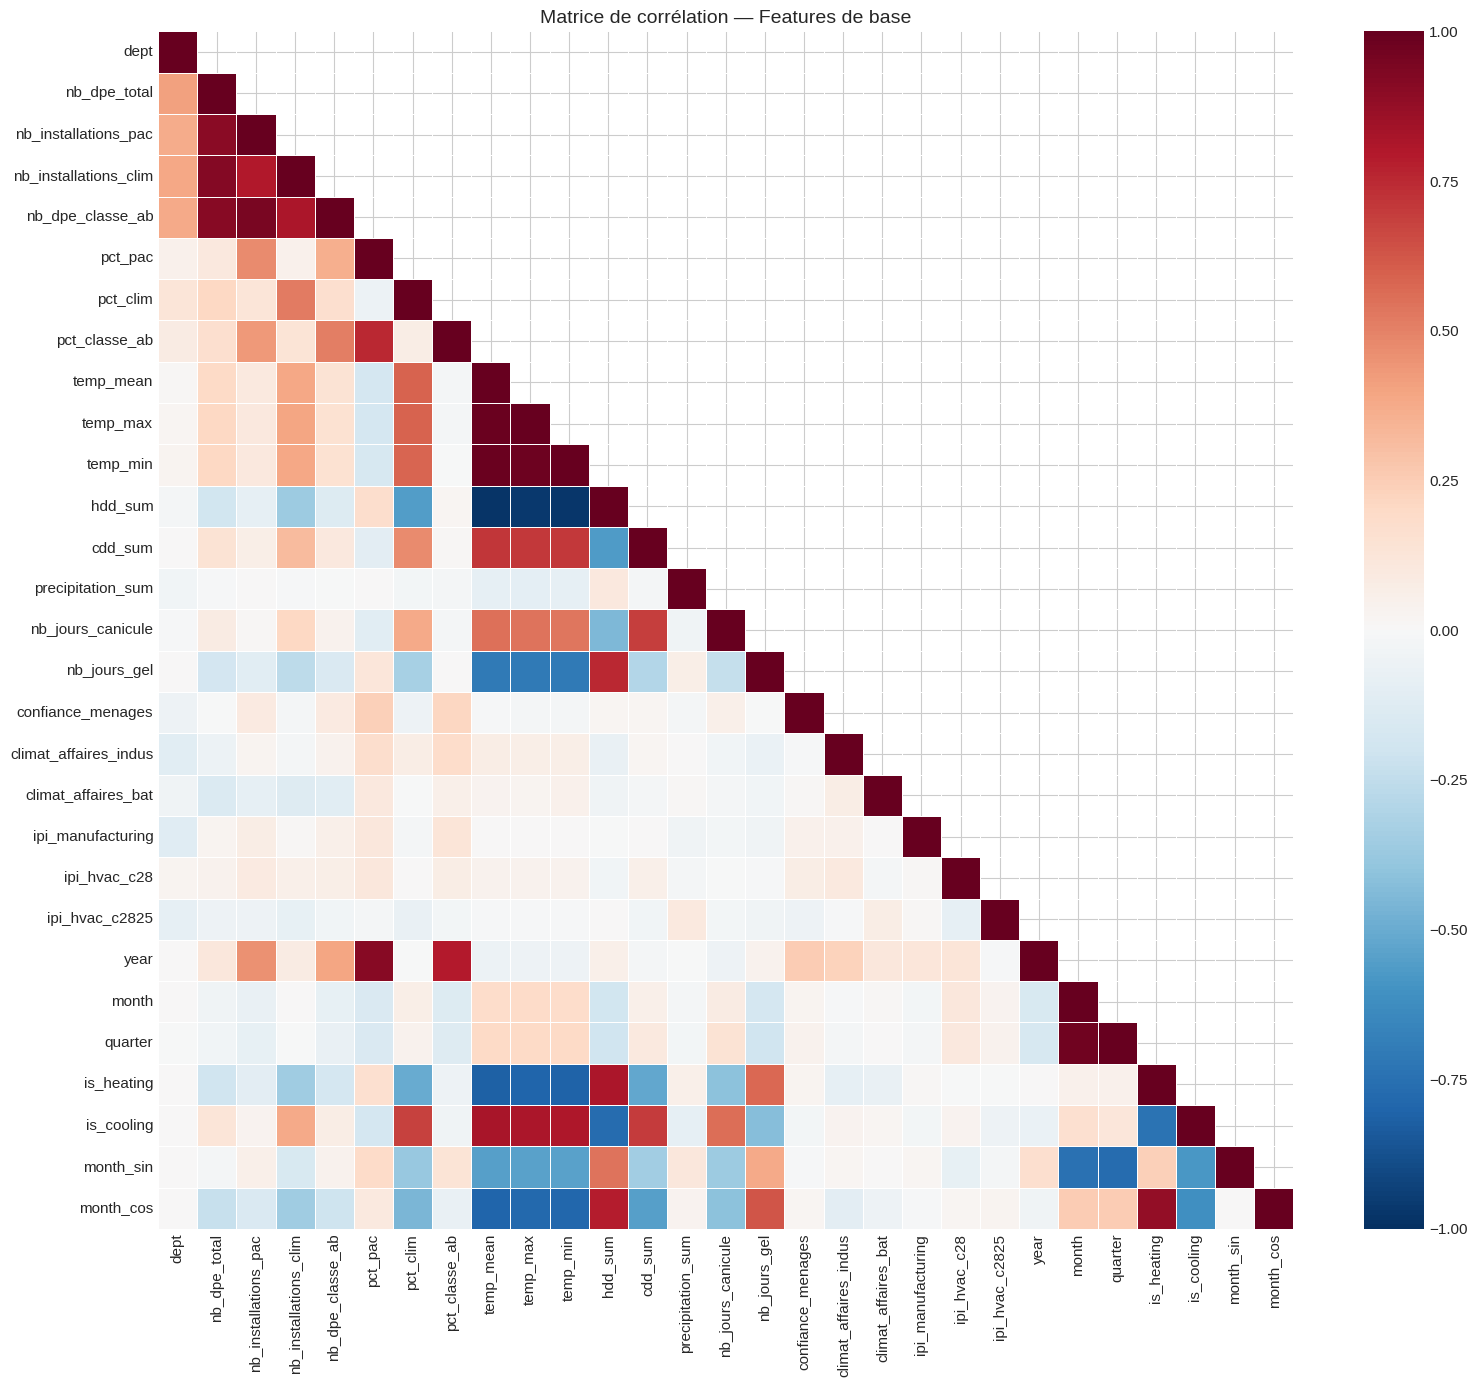

In [16]:
# ============================================================
# 7.1 — Matrice de corrélation (features de base)
# ============================================================
# Sélectionner les colonnes numériques pertinentes
numeric_cols = df.select_dtypes(include=[np.number]).columns
exclude = ['date_id', 'latitude', 'longitude']
corr_cols = [c for c in numeric_cols if c not in exclude]

corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix, mask=mask, annot=False, cmap='RdBu_r',
    center=0, vmin=-1, vmax=1, linewidths=0.5,
    ax=ax
)
ax.set_title('Matrice de corrélation — Features de base', fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
# ============================================================
# 7.2 — Top corrélations avec la cible (nb_installations_pac)
# ============================================================
target = 'nb_installations_pac'

corr_target = corr_matrix[target].drop(target).abs().sort_values(ascending=False)

print(f'Top 15 corrélations avec {target} :')
print('-' * 50)
for feat, corr_val in corr_target.head(15).items():
    sign = '+' if corr_matrix.loc[feat, target] > 0 else '-'
    print(f'  {feat:40s} : {sign}{corr_val:.3f}')

Top 15 corrélations avec nb_installations_pac :
--------------------------------------------------
  nb_dpe_classe_ab                         : +0.951
  nb_dpe_total                             : +0.900
  nb_installations_clim                    : +0.797
  pct_pac                                  : +0.476
  year                                     : +0.454
  pct_classe_ab                            : +0.431
  dept                                     : +0.372
  month_cos                                : -0.153
  pct_clim                                 : +0.131
  nb_jours_gel                             : -0.115
  is_heating                               : -0.107
  temp_max                                 : +0.105
  temp_min                                 : +0.102
  temp_mean                                : +0.094
  ipi_hvac_c28                             : +0.092


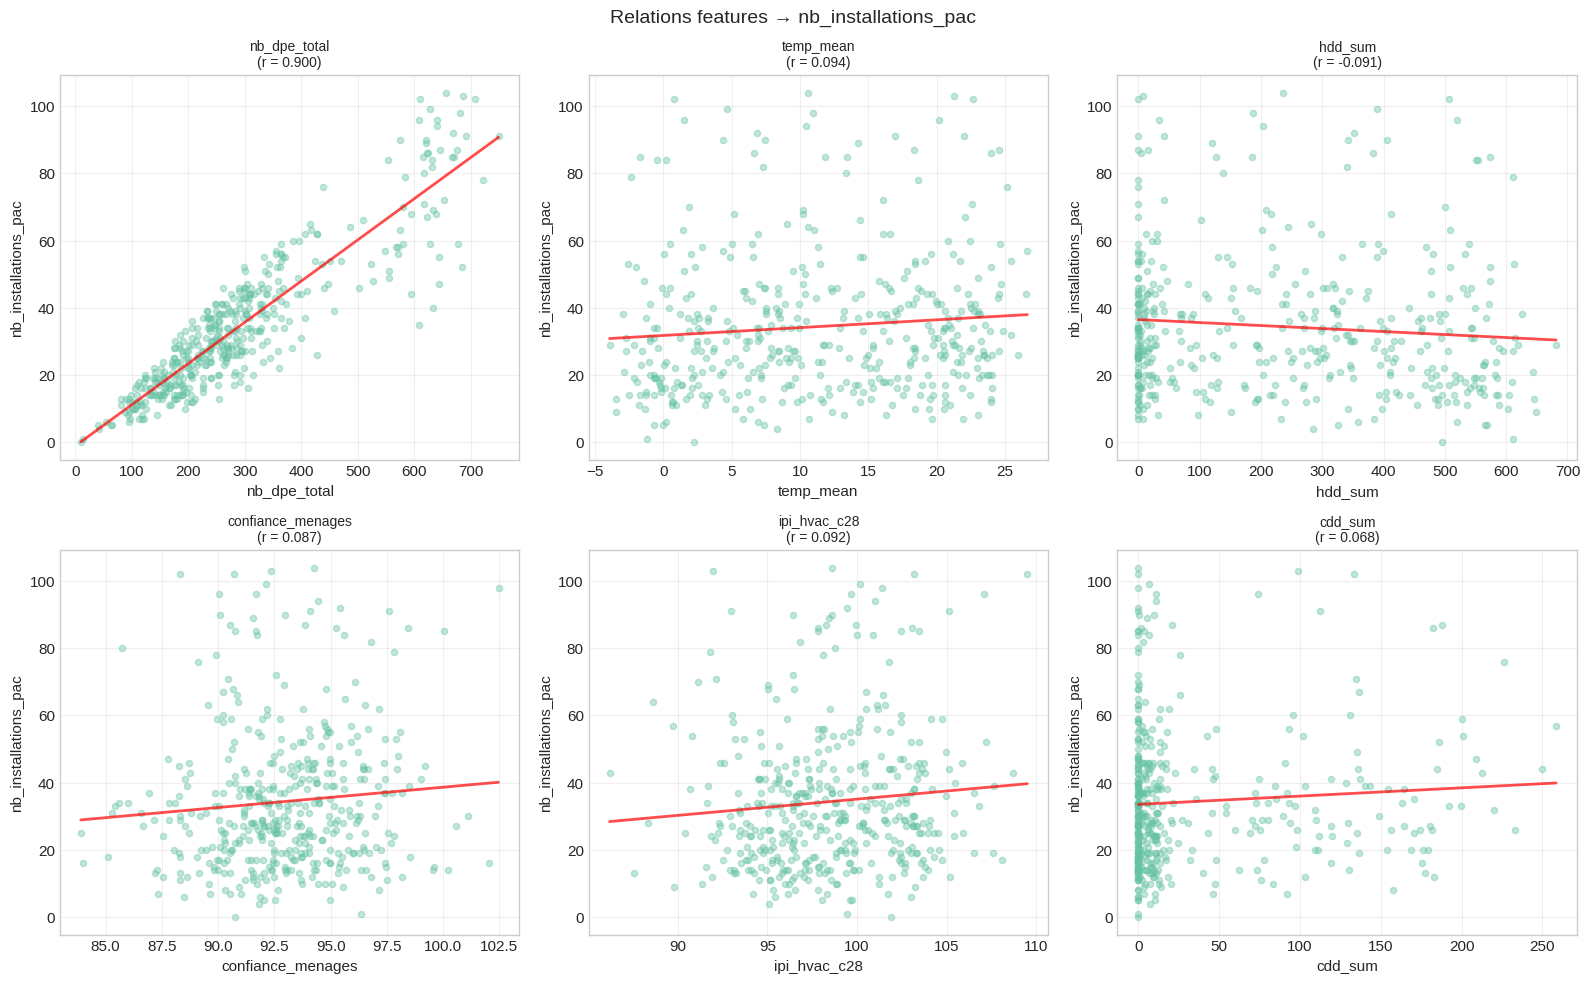

In [18]:
# ============================================================
# 7.3 — Scatter plots : features clés vs cible
# ============================================================
key_features = ['nb_dpe_total', 'temp_mean', 'hdd_sum', 
                'confiance_menages', 'ipi_hvac_c28', 'cdd_sum']
key_features = [f for f in key_features if f in df.columns]

n = len(key_features)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(f'Relations features → {target}', fontsize=14)

for ax, feat in zip(axes.flat, key_features):
    ax.scatter(df[feat], df[target], alpha=0.4, s=20)
    
    # Ligne de tendance
    mask = df[[feat, target]].dropna().index
    if len(mask) > 5:
        z = np.polyfit(df.loc[mask, feat], df.loc[mask, target], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df[feat].min(), df[feat].max(), 100)
        ax.plot(x_range, p(x_range), 'r-', linewidth=2, alpha=0.7)
    
    r = df[feat].corr(df[target])
    ax.set_title(f'{feat}\n(r = {r:.3f})', fontsize=10)
    ax.set_xlabel(feat)
    ax.set_ylabel(target)
    ax.grid(True, alpha=0.3)

# Masquer les axes vides si besoin
for i in range(n, len(axes.flat)):
    axes.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

---
## 8. Conclusions pour la modélisation

### Observations clés :

1. **Distribution des cibles** : les volumes varient fortement entre départements (Rhône >> Ardèche). Le modèle devra capturer cet effet géographique.

2. **Saisonnalité** : pattern saisonnier visible avec influence de la météo (HDD/CDD). Les features calendaires et météo seront importantes.

3. **Tendance** : croissance du marché PAC sur la période. La feature `year_trend` capturera cette dynamique.

4. **Corrélations** : `nb_dpe_total` est fortement corrélé avec les cibles (effet volume). Les indicateurs économiques (confiance, climat des affaires) apportent un signal additionnel.

### Implications pour le ML :
- **Ridge Regression** : bon candidat baseline avec les features linéaires
- **LightGBM** : pourra capturer les interactions non-linéaires (météo × confiance)
- **Prophet** : adapté à la composante série temporelle avec régresseurs
- **LSTM** : exploratoire, petit dataset (~288 lignes train)

In [19]:
# ============================================================
# Résumé statistique final
# ============================================================
print('=' * 60)
print('RÉSUMÉ EDA')
print('=' * 60)
print(f'Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print(f'Période : {df["date_id"].min()} → {df["date_id"].max()}')
print(f'Départements : {len(df["dept"].unique())}')
print(f'NaN total : {df.isna().sum().sum()} ({(df.isna().mean().mean()*100):.1f}%)')
print(f'\nVariable cible (nb_installations_pac) :')
print(f'  Moyenne : {df["nb_installations_pac"].mean():.1f}')
print(f'  Écart-type : {df["nb_installations_pac"].std():.1f}')
print(f'  Min : {df["nb_installations_pac"].min()}')
print(f'  Max : {df["nb_installations_pac"].max()}')
print('=' * 60)

RÉSUMÉ EDA
Dataset : 432 lignes × 35 colonnes
Période : 202107 → 202512
Départements : 8
NaN total : 0 (0.0%)

Variable cible (nb_installations_pac) :
  Moyenne : 34.4
  Écart-type : 20.8
  Min : 0
  Max : 104
